# 🔬 Skin Cancer Classification With PyTorch

🎯 **Project Overview**

This notebook demonstrates state-of-the-art skin cancer detection using the HAM10000 dataset - a comprehensive collection of 10,015 dermatoscopic images spanning 7 different skin lesion types. We tackle the challenging problem of **highly imbalanced medical data** through advanced data augmentation and class balancing techniques.

**Model**: ResNet50 with transfer learning 
**Key Achievement**: 98% accuracy on HAM10000

**Requirement**: GPU acceleration

**7 Skin Lesion Classes**:

1. **akiec** - Actinic keratoses and intraepithelial carcinoma
2. **bcc** - Basal cell carcinoma  
3. **bkl** - Benign keratosis-like lesions
4. **df** - Dermatofibroma
5. **mel** - Melanoma
6. **nv** - Melanocytic nevi
7. **vasc** - Vascular lesions


## 📚 Import Libraries 

In [1]:
# Standard library
import os
import random
from glob import glob

# Data & computation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Computer vision
import torchvision.models as models
from torchvision import transforms
from PIL import Image

# Utilities
from tqdm import tqdm

## 📥 Load Metadata

In [3]:
# Define dataset path
dataset_path = "/media/nisar/9C1454A8145486E4/Skin-Cancer/skin_cancer_files/input"
metadata = pd.read_csv(os.path.join(dataset_path, "HAM10000_metadata.csv"))
num_examples = len(metadata)
print(f"✅ Dataset loaded: {num_examples} samples")
metadata.head()

✅ Dataset loaded: 10015 samples


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


## 📊 EDA and Class Distribution

In [4]:
# Check missing values with percentages
print("\n🔍 Missing values:")
missing_percent = (metadata.isnull().sum() / len(metadata) * 100).round(2)
for col, percent in missing_percent.items():
    print(f"{col}: {percent}%")


🔍 Missing values:
lesion_id: 0.0%
image_id: 0.0%
dx: 0.0%
dx_type: 0.0%
age: 0.57%
sex: 0.0%
localization: 0.0%


0.57% missing values is negligible - less than 1% of the dataset. Leave them as-is; most ML models can handle such a small amount of missing data without issues.

In [5]:
# Create path mapping from both image folders
image_path = {}
for part in ['HAM10000_images_part_1', 'HAM10000_images_part_2']:
    folder_path = os.path.join(dataset_path, part)
    part_images = {os.path.splitext(os.path.basename(x))[0]: x
                   for x in glob(os.path.join(folder_path, '*.jpg'))}
    image_path.update(part_images)

print(f"Found {len(image_path)} images")

Found 10015 images


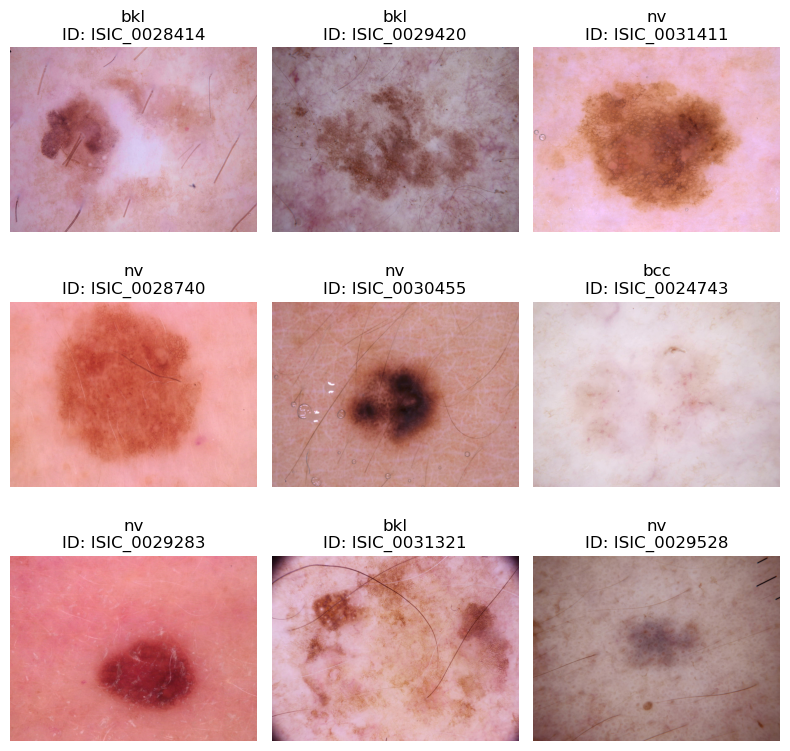

In [6]:
# Get 9 random image IDs
random_ids = random.sample(list(image_path.keys()), 9)

plt.figure(figsize=(8, 8))
for i, img_id in enumerate(random_ids):
   img_path = image_path[img_id]
   img = Image.open(img_path) 
   
   # Find the label for this image ID
   row = metadata[metadata['image_id'] == img_id]
   if not row.empty:
       label = row['dx'].iloc[0]
   else:
       label = 'Unknown'
   
   plt.subplot(3, 3, i+1)
   plt.imshow(img)
   plt.title(f'{label}\nID: {img_id}')
   plt.axis('off')

plt.tight_layout()
plt.show()

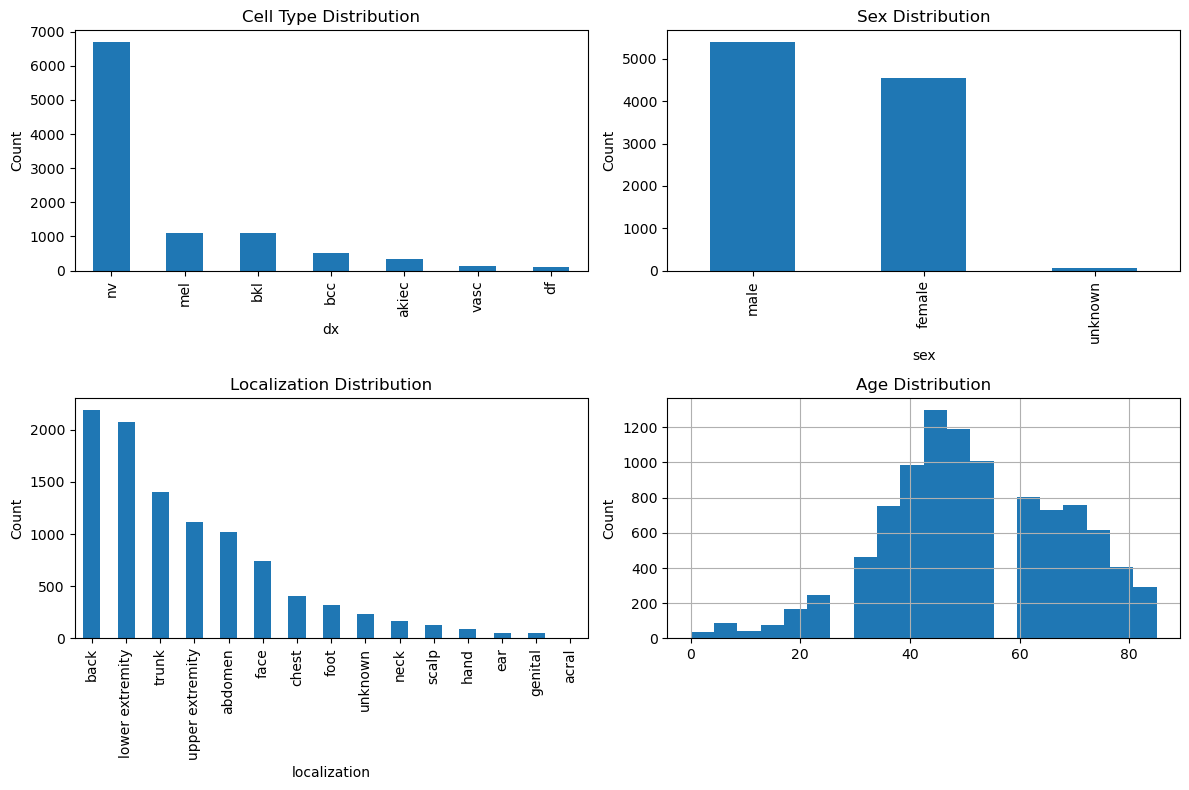

In [7]:
# Simple data distribution visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Cell type distribution
metadata['dx'].value_counts().plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Cell Type Distribution')
axes[0,0].set_ylabel('Count')

# Sex distribution  
metadata['sex'].value_counts().plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Sex Distribution')
axes[0,1].set_ylabel('Count')

# Localization distribution
metadata['localization'].value_counts().plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Localization Distribution')
axes[1,0].set_ylabel('Count')

# Age distribution (simple histogram)
metadata['age'].hist(bins=20, ax=axes[1,1])
axes[1,1].set_title('Age Distribution')
axes[1,1].set_ylabel('Count')

plt.tight_layout()
plt.show()

## ⚖️ Balance Dataset

Were are going to use class-specific multiplication rates:

- Small classes get big multipliers: df × 50, akiec × 15, vasc × 40
- Large classes get small multipliers: nv × 1 (unchanged)
- Medium classes get medium multipliers: bcc × 10, mel × 5

In [8]:
label_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
metadata['label'] = metadata['dx'].map(lambda x: label_names.index(x))
print("Imbalanced dataset distribution:")
print(metadata['label'].value_counts())

# different multipliers per class 
data_aug_rate = [15, 10, 5, 50, 5, 1, 40]
df_0 = metadata[metadata['label'] == 0]  # akiec
df_1 = metadata[metadata['label'] == 1]  # bcc
df_2 = metadata[metadata['label'] == 2]  # bkl
df_3 = metadata[metadata['label'] == 3]  # df
df_4 = metadata[metadata['label'] == 4]  # mel
df_5 = metadata[metadata['label'] == 5]  # nv
df_6 = metadata[metadata['label'] == 6]  # vasc

dfs = [df_0, df_1, df_2, df_3, df_4, df_5, df_6] 
balanced_dfs = []

for i, (df_class, rate) in enumerate(zip(dfs, data_aug_rate)):
    if rate > 0:
        # Multiply the class by the rate
        augmented_df = pd.concat([df_class] * rate, ignore_index=True)
        balanced_dfs.append(augmented_df)
    else:
        # Rate 0 means use original
        balanced_dfs.append(df_class)

metadata_balanced = pd.concat(balanced_dfs, ignore_index=True)

print("Balanced dataset distribution:")
print(metadata_balanced['label'].value_counts().sort_index())

Imbalanced dataset distribution:
label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64
Balanced dataset distribution:
label
0    4905
1    5140
2    5495
3    5750
4    5565
5    6705
6    5680
Name: count, dtype: int64


## 🏋️‍♂️Train and Evaluate ResNet50 

In [9]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
             for x in glob(os.path.join(dataset_path, '*', '*.jpg'))}
metadata_balanced['path'] = metadata_balanced['image_id'].map(image_path.get)
metadata_balanced.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,path
0,HAM_0002644,ISIC_0029417,akiec,histo,80.0,female,neck,0,/media/nisar/9C1454A8145486E4/Skin-Cancer/skin...
1,HAM_0006002,ISIC_0029915,akiec,histo,50.0,female,face,0,/media/nisar/9C1454A8145486E4/Skin-Cancer/skin...
2,HAM_0000549,ISIC_0029360,akiec,histo,70.0,male,upper extremity,0,/media/nisar/9C1454A8145486E4/Skin-Cancer/skin...
3,HAM_0000549,ISIC_0026152,akiec,histo,70.0,male,upper extremity,0,/media/nisar/9C1454A8145486E4/Skin-Cancer/skin...
4,HAM_0000673,ISIC_0029659,akiec,histo,70.0,female,face,0,/media/nisar/9C1454A8145486E4/Skin-Cancer/skin...


In [10]:
# Set up transforms
input_size = 224
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
    transforms.ToTensor(), 
    transforms.Normalize(norm_mean, norm_std)
])

val_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)), 
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

train_df, test_df = train_test_split(metadata_balanced, test_size=0.2, random_state=42, stratify=metadata_balanced['label'])
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42, stratify=train_df['label'])

# Print dataset split sizes and class distribution
print(f"Dataset splits - Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
print(f"Class distribution - Train: {train_df['label'].value_counts().to_dict()}")

Dataset splits - Train: 23544, Val: 7848, Test: 7848
Class distribution - Train: {5: 4023, 3: 3450, 6: 3408, 4: 3339, 2: 3297, 1: 3084, 0: 2943}


In [11]:
# Create custom dataset class
class SkinDataset(Dataset):
   def __init__(self, dataframe, transform=None):
       self.df = dataframe.reset_index(drop=True)
       # Pre-extract paths and labels for faster access
       self.image_paths = dataframe['path'].values
       self.labels = dataframe['label'].values
       self.transform = transform
   
   def __len__(self):
       return len(self.df)
   
   def __getitem__(self, idx):
       image_path = self.image_paths[idx]  # Fast numpy array access
       label = self.labels[idx]            # Fast numpy array access
       
       image = Image.open(image_path)
       
       if self.transform:
           image = self.transform(image)
       
       return image, label

# Create datasets with transforms
train_dataset = SkinDataset(train_df, transform=train_transform)
val_dataset = SkinDataset(val_df, transform=val_transform)
test_dataset = SkinDataset(test_df, transform=val_transform)

In [12]:
# Enable PyTorch optimizations
torch.backends.cudnn.benchmark = True  # Optimize for fixed input sizes

# Create DataLoaders
# Settings optimized for different hardware:
# - Kaggle T4 x2: Current settings work well
# - Local RTX 40/50 series: Can use batch_size=128+ for training, 256+ for val/test, num_workers=8+
train_loader = DataLoader(
   train_dataset, 
   batch_size=128,             # For RTX 40/50: use 128+ (more VRAM available)
   shuffle=True, 
   num_workers=4,              # For RTX 40/50: use 8+ workers (more CPU cores)
   pin_memory=True,            
   persistent_workers=True,    
   prefetch_factor=4           # For RTX 40/50: use 4+ prefetch
)

val_loader = DataLoader(
   val_dataset, 
   batch_size=256,             
   shuffle=False, 
   num_workers=4,              # For RTX 40/50: use 6+ workers
   pin_memory=True,            
   persistent_workers=True,
   prefetch_factor=4
)

test_loader = DataLoader(
   test_dataset, 
   batch_size=256,             
   shuffle=False, 
   num_workers=4,              # For RTX 40/50: use 4+ workers
   pin_memory=True,
   persistent_workers=True,    
   prefetch_factor=4
)


In [13]:
# Create ResNet model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 7)
model = model.to(device)

# Create criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
def train_cnn_model(
    model,
    train_loader, 
    val_loader,
    test_loader,
    criterion,
    optimizer,
    num_epochs=50,
    patience=10):
    
    print(f"Training {model.__class__.__name__} for {num_epochs} epochs (patience: {patience})")
    print("-" * 60)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    # Early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    best_epoch = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            current_loss = train_loss / (progress_bar.n + 1)
            current_acc = (train_correct / train_total) * 100
            progress_bar.set_postfix({
                'loss': f'{current_loss:.4f}',
                'accuracy': f'{current_acc:.2f}%'
            })

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate final metrics
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total
        train_loss_avg = train_loss / len(train_loader)
        val_loss_avg = val_loss / len(val_loader)

        # Store metrics
        train_losses.append(train_loss_avg)
        val_losses.append(val_loss_avg)
        train_accs.append(train_acc * 100)
        val_accs.append(val_acc * 100)

        # Print metrics
        print(f'Epoch {epoch+1}: loss: {train_loss_avg:.4f} - accuracy: {train_acc*100:.2f}% - val_loss: {val_loss_avg:.4f} - val_accuracy: {val_acc*100:.2f}%')

        # Early stopping check
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            best_epoch = epoch + 1
            print('Validation loss improved. Best model updated.')
        else:
            patience_counter += 1
            print(f'No improvement. Patience: {patience_counter}/{patience}')

            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f'Best model from epoch {best_epoch} loaded')

    # Test evaluation
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = (test_correct / test_total) * 100
    test_loss_avg = test_loss / len(test_loader)

    print(f"\nTest Results:")
    print(f"Test Loss: {test_loss_avg:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%")

    # Generate and display confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_names, yticklabels=label_names)
    plt.title(f'Confusion Matrix - {model.__class__.__name__}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Plot fractional incorrect misclassifications
    incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(7), incorr_fraction)
    plt.xlabel('True Label')
    plt.ylabel('Fraction of incorrect predictions')
    plt.title('Fractional Incorrect Misclassifications')
    plt.xticks(np.arange(7), label_names, rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Generate and display classification report
    report = classification_report(all_labels, all_predictions, target_names=label_names, output_dict=True, zero_division=0)
    report_text = classification_report(all_labels, all_predictions, target_names=label_names, zero_division=0)

    # Print classification report
    print("\nClassification Report:")
    print("="*50)
    print(report_text)
    print("="*50)

    # Create and display training history plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs_range = range(1, len(train_losses) + 1)
    
    ax1.plot(epochs_range, train_losses, 'y-', label='Training Loss', linewidth=2)
    ax1.plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(epochs_range, train_accs, 'y-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs_range, val_accs, 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    # Print final summary
    print("\n" + "="*60)
    print("🎉 TRAINING COMPLETED SUCCESSFULLY! 🎉")
    print("="*60)
    print(f"✅ Total epochs trained: {len(train_losses)}")
    print(f"✅ Best epoch: {best_epoch}")
    print(f"✅ Best validation loss: {best_val_loss:.4f}")
    print(f"✅ Best train accuracy: {max(train_accs):.2f}%")
    print(f"✅ Best val accuracy: {max(val_accs):.2f}%")
    print(f"✅ Final test accuracy: {test_acc:.2f}%")
    print("="*60)
    print("Training and evaluation completed!")

    return train_losses, val_losses, train_accs, val_accs, test_loss_avg, test_acc

Training ResNet for 30 epochs (patience: 10)
------------------------------------------------------------


Epoch 1/30: 100%|██████████| 184/184 [01:34<00:00,  1.95it/s, loss=0.6615, accuracy=75.69%]


Epoch 1: loss: 0.6615 - accuracy: 75.69% - val_loss: 0.4442 - val_accuracy: 83.38%
Validation loss improved. Best model updated.


Epoch 2/30: 100%|██████████| 184/184 [01:28<00:00,  2.09it/s, loss=0.4013, accuracy=85.07%]


Epoch 2: loss: 0.4013 - accuracy: 85.07% - val_loss: 0.5675 - val_accuracy: 79.87%
No improvement. Patience: 1/10


Epoch 3/30: 100%|██████████| 184/184 [01:28<00:00,  2.09it/s, loss=0.3127, accuracy=88.20%]


Epoch 3: loss: 0.3127 - accuracy: 88.20% - val_loss: 0.2672 - val_accuracy: 89.81%
Validation loss improved. Best model updated.


Epoch 4/30: 100%|██████████| 184/184 [01:28<00:00,  2.09it/s, loss=0.2515, accuracy=90.44%]


Epoch 4: loss: 0.2515 - accuracy: 90.44% - val_loss: 0.3290 - val_accuracy: 88.15%
No improvement. Patience: 1/10


Epoch 5/30: 100%|██████████| 184/184 [01:28<00:00,  2.09it/s, loss=0.2209, accuracy=91.72%]


Epoch 5: loss: 0.2209 - accuracy: 91.72% - val_loss: 0.2427 - val_accuracy: 91.11%
Validation loss improved. Best model updated.


Epoch 6/30: 100%|██████████| 184/184 [01:27<00:00,  2.09it/s, loss=0.1896, accuracy=93.06%]


Epoch 6: loss: 0.1896 - accuracy: 93.06% - val_loss: 0.2152 - val_accuracy: 91.87%
Validation loss improved. Best model updated.


Epoch 7/30: 100%|██████████| 184/184 [01:28<00:00,  2.09it/s, loss=0.1690, accuracy=93.82%]


Epoch 7: loss: 0.1690 - accuracy: 93.82% - val_loss: 0.1664 - val_accuracy: 93.23%
Validation loss improved. Best model updated.


Epoch 8/30: 100%|██████████| 184/184 [01:28<00:00,  2.09it/s, loss=0.1379, accuracy=95.12%]


Epoch 8: loss: 0.1379 - accuracy: 95.12% - val_loss: 0.1646 - val_accuracy: 93.74%
Validation loss improved. Best model updated.


Epoch 9/30: 100%|██████████| 184/184 [01:28<00:00,  2.09it/s, loss=0.1330, accuracy=95.11%]


Epoch 9: loss: 0.1330 - accuracy: 95.11% - val_loss: 0.1601 - val_accuracy: 94.30%
Validation loss improved. Best model updated.


Epoch 10/30: 100%|██████████| 184/184 [01:28<00:00,  2.09it/s, loss=0.1235, accuracy=95.40%]


Epoch 10: loss: 0.1235 - accuracy: 95.40% - val_loss: 0.1526 - val_accuracy: 95.13%
Validation loss improved. Best model updated.


Epoch 11/30: 100%|██████████| 184/184 [01:27<00:00,  2.09it/s, loss=0.1161, accuracy=95.69%]


Epoch 11: loss: 0.1161 - accuracy: 95.69% - val_loss: 0.1941 - val_accuracy: 93.34%
No improvement. Patience: 1/10


Epoch 12/30: 100%|██████████| 184/184 [01:27<00:00,  2.09it/s, loss=0.1019, accuracy=96.26%]


Epoch 12: loss: 0.1019 - accuracy: 96.26% - val_loss: 0.1288 - val_accuracy: 95.31%
Validation loss improved. Best model updated.


Epoch 13/30: 100%|██████████| 184/184 [01:28<00:00,  2.09it/s, loss=0.0885, accuracy=96.65%]


Epoch 13: loss: 0.0885 - accuracy: 96.65% - val_loss: 0.2913 - val_accuracy: 91.86%
No improvement. Patience: 1/10


Epoch 14/30: 100%|██████████| 184/184 [01:27<00:00,  2.09it/s, loss=0.0846, accuracy=96.92%]


Epoch 14: loss: 0.0846 - accuracy: 96.92% - val_loss: 0.2144 - val_accuracy: 93.16%
No improvement. Patience: 2/10


Epoch 15/30: 100%|██████████| 184/184 [01:27<00:00,  2.09it/s, loss=0.0837, accuracy=97.01%]


Epoch 15: loss: 0.0837 - accuracy: 97.01% - val_loss: 0.1385 - val_accuracy: 95.45%
No improvement. Patience: 3/10


Epoch 16/30: 100%|██████████| 184/184 [01:27<00:00,  2.09it/s, loss=0.0784, accuracy=97.11%]


Epoch 16: loss: 0.0784 - accuracy: 97.11% - val_loss: 0.2447 - val_accuracy: 92.58%
No improvement. Patience: 4/10


Epoch 17/30: 100%|██████████| 184/184 [01:27<00:00,  2.09it/s, loss=0.0763, accuracy=97.28%]


Epoch 17: loss: 0.0763 - accuracy: 97.28% - val_loss: 0.1431 - val_accuracy: 94.79%
No improvement. Patience: 5/10


Epoch 18/30: 100%|██████████| 184/184 [01:27<00:00,  2.09it/s, loss=0.0620, accuracy=97.84%]


Epoch 18: loss: 0.0620 - accuracy: 97.84% - val_loss: 0.1323 - val_accuracy: 95.69%
No improvement. Patience: 6/10


Epoch 19/30: 100%|██████████| 184/184 [01:27<00:00,  2.09it/s, loss=0.0710, accuracy=97.58%]


Epoch 19: loss: 0.0710 - accuracy: 97.58% - val_loss: 0.1470 - val_accuracy: 95.13%
No improvement. Patience: 7/10


Epoch 20/30: 100%|██████████| 184/184 [01:27<00:00,  2.09it/s, loss=0.0634, accuracy=97.76%]


Epoch 20: loss: 0.0634 - accuracy: 97.76% - val_loss: 0.0989 - val_accuracy: 96.92%
Validation loss improved. Best model updated.


Epoch 21/30: 100%|██████████| 184/184 [01:27<00:00,  2.09it/s, loss=0.0550, accuracy=98.05%]


Epoch 21: loss: 0.0550 - accuracy: 98.05% - val_loss: 0.0892 - val_accuracy: 97.09%
Validation loss improved. Best model updated.


Epoch 22/30: 100%|██████████| 184/184 [01:27<00:00,  2.09it/s, loss=0.0495, accuracy=98.27%]


Epoch 22: loss: 0.0495 - accuracy: 98.27% - val_loss: 0.0997 - val_accuracy: 97.22%
No improvement. Patience: 1/10


Epoch 23/30: 100%|██████████| 184/184 [01:27<00:00,  2.09it/s, loss=0.0462, accuracy=98.42%]


Epoch 23: loss: 0.0462 - accuracy: 98.42% - val_loss: 0.0950 - val_accuracy: 97.45%
No improvement. Patience: 2/10


Epoch 24/30: 100%|██████████| 184/184 [01:27<00:00,  2.09it/s, loss=0.0497, accuracy=98.18%]


Epoch 24: loss: 0.0497 - accuracy: 98.18% - val_loss: 0.0990 - val_accuracy: 97.18%
No improvement. Patience: 3/10


Epoch 25/30: 100%|██████████| 184/184 [01:27<00:00,  2.10it/s, loss=0.0465, accuracy=98.37%]


Epoch 25: loss: 0.0465 - accuracy: 98.37% - val_loss: 0.0931 - val_accuracy: 97.02%
No improvement. Patience: 4/10


Epoch 26/30: 100%|██████████| 184/184 [01:24<00:00,  2.17it/s, loss=0.0498, accuracy=98.24%]


Epoch 26: loss: 0.0498 - accuracy: 98.24% - val_loss: 0.0986 - val_accuracy: 97.07%
No improvement. Patience: 5/10


Epoch 27/30: 100%|██████████| 184/184 [01:24<00:00,  2.17it/s, loss=0.0494, accuracy=98.29%]


Epoch 27: loss: 0.0494 - accuracy: 98.29% - val_loss: 0.0924 - val_accuracy: 97.36%
No improvement. Patience: 6/10


Epoch 28/30: 100%|██████████| 184/184 [01:24<00:00,  2.18it/s, loss=0.0344, accuracy=98.86%]


Epoch 28: loss: 0.0344 - accuracy: 98.86% - val_loss: 0.1099 - val_accuracy: 96.85%
No improvement. Patience: 7/10


Epoch 29/30: 100%|██████████| 184/184 [01:28<00:00,  2.09it/s, loss=0.0407, accuracy=98.68%]


Epoch 29: loss: 0.0407 - accuracy: 98.68% - val_loss: 0.1926 - val_accuracy: 94.30%
No improvement. Patience: 8/10


Epoch 30/30: 100%|██████████| 184/184 [01:28<00:00,  2.09it/s, loss=0.0447, accuracy=98.48%]


Epoch 30: loss: 0.0447 - accuracy: 98.48% - val_loss: 0.0738 - val_accuracy: 97.96%
Validation loss improved. Best model updated.
Best model from epoch 30 loaded

Test Results:
Test Loss: 0.0790
Test Accuracy: 97.80%


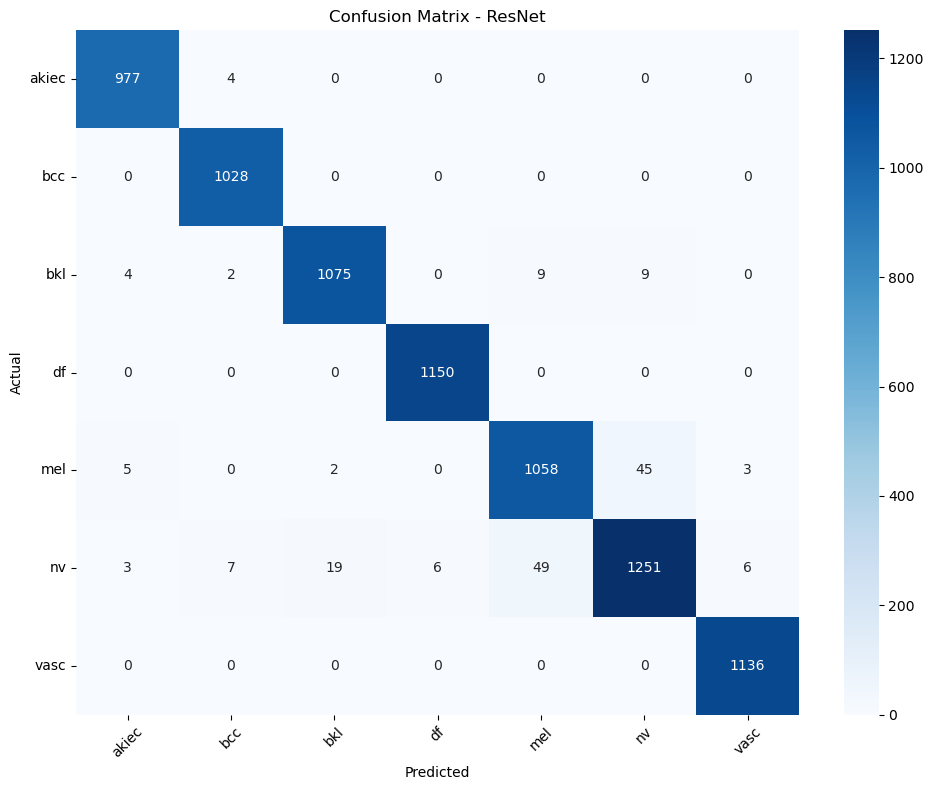

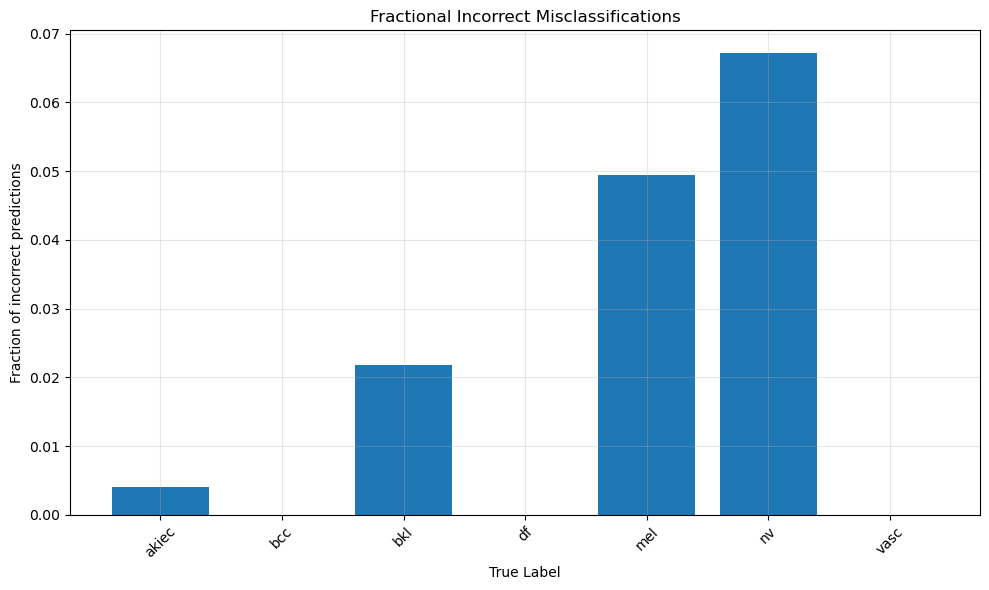


Classification Report:
              precision    recall  f1-score   support

       akiec       0.99      1.00      0.99       981
         bcc       0.99      1.00      0.99      1028
         bkl       0.98      0.98      0.98      1099
          df       0.99      1.00      1.00      1150
         mel       0.95      0.95      0.95      1113
          nv       0.96      0.93      0.95      1341
        vasc       0.99      1.00      1.00      1136

    accuracy                           0.98      7848
   macro avg       0.98      0.98      0.98      7848
weighted avg       0.98      0.98      0.98      7848



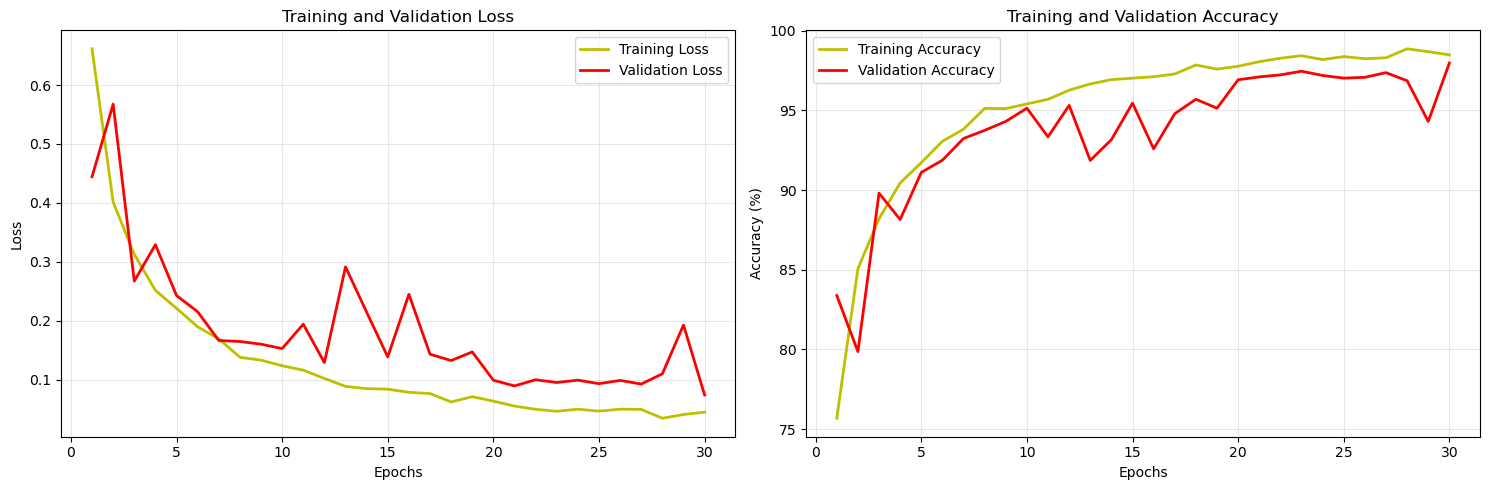


🎉 TRAINING COMPLETED SUCCESSFULLY! 🎉
✅ Total epochs trained: 30
✅ Best epoch: 30
✅ Best validation loss: 0.0738
✅ Best train accuracy: 98.86%
✅ Best val accuracy: 97.96%
✅ Final test accuracy: 97.80%
Training and evaluation completed!


In [16]:
# Here in Kaggle we are limited, so we just demo with 30 epochs / patience=10
train_losses, val_losses, train_accs, val_accs, test_loss, test_accuracy = train_cnn_model(
    model, train_loader, val_loader, test_loader, criterion, optimizer,
    num_epochs=30, patience=10
)

# In a real run (outside Kaggle limits), train for 150 epochs with patience=20:
# train_cnn_model(model, train_loader, val_loader, test_loader, criterion, optimizer,
#                 num_epochs=150, patience=20)

In [ ]:
# Add this at the end of your notebook after training

import gradio as gr
import torch.nn.functional as F

# Save the trained model (add this right after training)
torch.save(model.state_dict(), 'skin_cancer_model.pth')

# Define label mappings
label_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
cancerous_classes = {'akiec', 'bcc', 'mel'}  # These are considered cancerous

# Load the model (for deployment or separate script)
def load_model():
    loaded_model = models.resnet50(weights=None)  # Don't use pretrained here
    loaded_model.fc = nn.Linear(loaded_model.fc.in_features, 7)
    loaded_model.load_state_dict(torch.load('skin_cancer_model.pth'))
    loaded_model = loaded_model.to(device)
    loaded_model.eval()
    return loaded_model

# Prediction function
def predict_skin_lesion(image):
    # Use the validation transform
    img_tensor = val_transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(img_tensor)  # Use 'model' if in same session, or load_model() if separate
        probs = F.softmax(output, dim=1)[0]
        pred_idx = torch.argmax(probs).item()
        pred_label = label_names[pred_idx]
        is_cancerous = pred_label in cancerous_classes
        
        # Format probabilities
        prob_scores = {label_names[i]: f"{probs[i].item() * 100:.2f}%" for i in range(len(label_names))}
    
    result = (
        f"Predicted Type: {pred_label}\n"
        f"Cancerous: {'Yes' if is_cancerous else 'No'}\n"
        f"Probability Scores:\n" + "\n".join([f"{k}: {v}" for k, v in prob_scores.items()])
    )
    return result

# Create Gradio interface
demo = gr.Interface(
    fn=predict_skin_lesion,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Skin Cancer Detection",
    description="Upload a skin lesion image to predict the type and whether it's cancerous, along with probability scores."
)

# Launch the interface
demo.launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.
